In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, brier_score_loss, make_scorer, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
# Adjust dataframe display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Load df
df = pd.read_csv("df.csv")

In [4]:
# Remove odds columns and separate features from target
features = [col for col in df.columns if col != "A Won" and 'Odds' not in col]
X = df[features]
y = df["A Won"]

In [5]:
# Train/test split
X_train = X[df["Year"] < 2023]
y_train = y[df["Year"] < 2023]
X_test = X[df["Year"] >= 2023]
y_test = y[df["Year"] >= 2023]

In [6]:
# Initialise Base model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=1,
    n_jobs=-1
)

In [7]:
# Hyperparameter search space
parameter_grid = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.05, 0.1, 0.15],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [3, 5, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "gamma": [0, 1, 5],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [0, 1, 5]
}


In [8]:
# Indices for train/val split for hyperparameter tuning
train_indices = X_train.index[X_train['Year'] < 2020].tolist()
val_indices = X_train.index[(X_train['Year'] >= 2020) & (X_train['Year'] <= 2022)].tolist()
cv_split = [(train_indices, val_indices)]

In [9]:
# Randomised search setup
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=parameter_grid,
    n_iter=100,
    scoring=make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False),
    cv=cv_split,
    random_state=1,
    n_jobs=-1,
    verbose=1
)

In [10]:
# Find best hyperparameters using random search
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


c:\Users\olive\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\olive\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


In [11]:
# Initialise best model
best_model = XGBClassifier(
    **random_search.best_params_,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=1,
    n_jobs=-1
)

In [12]:
# Train best model
best_model.fit(X_train, y_train)

c:\Users\olive\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [13]:
# Use model on train and test set
y_pred_train = best_model.predict(X_train)
y_prob_pred_train = best_model.predict_proba(X_train)[:, 1]
y_pred_test = best_model.predict(X_test)
y_prob_pred_test = best_model.predict_proba(X_test)[:, 1]

In [14]:
# Find accuracy and brier score for train and test set
accuracy_train = accuracy_score(y_train, y_pred_train)
brier_train = brier_score_loss(y_train, y_prob_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
brier_test = brier_score_loss(y_test, y_prob_pred_test)
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Brier score: {brier_train}")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Brier score: {brier_test}")

Train Accuracy: 0.7013003504850917
Train Brier score: 0.19294246000817805
Test Accuracy: 0.6490158026060439
Test Brier score: 0.21309179374596038


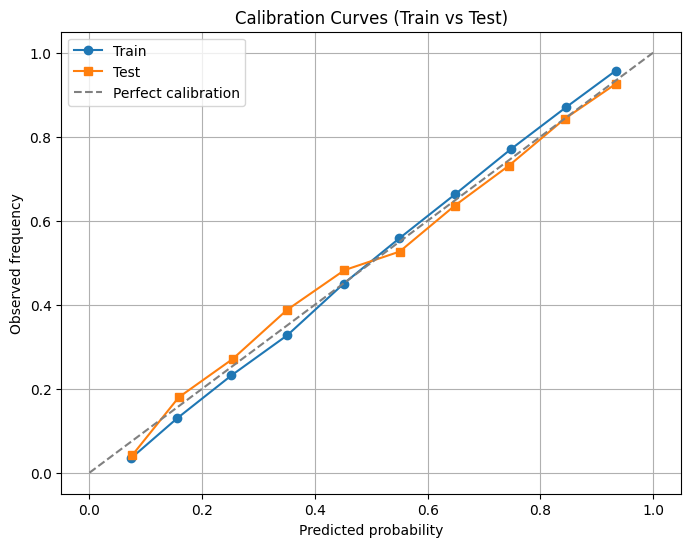

In [15]:
# Display calibration curves
prob_true_train, prob_pred_train = calibration_curve(y_train, y_prob_pred_train, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_prob_pred_test, n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Train')
plt.plot(prob_pred_test, prob_true_test, marker='s', label='Test')
plt.plot([0,1],[0,1],'--', color='gray', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curves (Train vs Test)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Other model statistics on test set
print("ROC AUC:", roc_auc_score(y_test, y_prob_pred_test))
print("F1:", f1_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("\nClassification report:\n", classification_report(y_test, y_pred_test))

ROC AUC: 0.7185919748598955
F1: 0.6551348406428766
Precision: 0.6535326086956522
Recall: 0.6567449481157838

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64      3552
           1       0.65      0.66      0.66      3662

    accuracy                           0.65      7214
   macro avg       0.65      0.65      0.65      7214
weighted avg       0.65      0.65      0.65      7214



In [17]:
# Create df for EV calculations
ev_df = pd.DataFrame(index=X_test.index)

In [18]:
# Add data and predictions to EV df
ev_df['A Pred'] = y_prob_pred_test
ev_df['B Pred'] = 1 - y_prob_pred_test
ev_df['A Res'] = y_test
ev_df['B Res'] = 1 - y_test
ev_df['A B365 Odds'] = df.loc[ev_df.index, 'A Bet365 Odds']
ev_df['B B365 Odds'] = df.loc[ev_df.index, 'B Bet365 Odds']
ev_df['A Pinn Odds'] = df.loc[ev_df.index, 'A Pinnacle Odds']
ev_df['B Pinn Odds'] = df.loc[ev_df.index, 'B Pinnacle Odds']

In [19]:
# Calculate implied odds with bookmaker's edge removed
ev_df['A B365 Implied Prob'] = (
    (1 / ev_df['A B365 Odds']) / (1 / ev_df['A B365 Odds'] + 1 / ev_df['B B365 Odds'])
)
ev_df['B B365 Implied Prob'] = (
    (1 / ev_df['B B365 Odds']) / (1 / ev_df['A B365 Odds'] + 1 / ev_df['B B365 Odds'])
)
ev_df['A Pinn Implied Prob'] = (
    (1 / ev_df['A Pinn Odds']) / (1 / ev_df['A Pinn Odds'] + 1 / ev_df['B Pinn Odds'])
)
ev_df['B Pinn Implied Prob'] = (
    (1 / ev_df['B Pinn Odds']) / (1 / ev_df['A Pinn Odds'] + 1 / ev_df['B Pinn Odds'])
)

In [20]:
# Calculate returns for all bets
returns_b365_A = np.where(ev_df['A Res'] == 1, ev_df['A B365 Odds'] - 1, -1)
returns_b365_B = np.where(ev_df['B Res'] == 1, ev_df['B B365 Odds'] - 1, -1)
returns_pinn_A = np.where(ev_df['A Res'] == 1, ev_df['A Pinn Odds'] - 1, -1)
returns_pinn_B = np.where(ev_df['B Res'] == 1, ev_df['B Pinn Odds'] - 1, -1)

In [21]:
# Define a threshold for when to make a bet
threshold = 0.2

In [22]:
# Check which bets satisfy threshold
bet_on_A_b365 = ev_df['A Pred'] > ev_df['A B365 Implied Prob'] + threshold
bet_on_B_b365 = ev_df['B Pred'] > ev_df['B B365 Implied Prob'] + threshold
bet_on_A_pinn = ev_df['A Pred'] > ev_df['A Pinn Implied Prob'] + threshold
bet_on_B_pinn = ev_df['B Pred'] > ev_df['B Pinn Implied Prob'] + threshold

In [23]:
# Calculate EV and bet count for each betting company
ev_b365 = np.sum(returns_b365_A[bet_on_A_b365]) + np.sum(returns_b365_B[bet_on_B_b365])
bet_count_b365 = np.sum(bet_on_A_b365) + np.sum(bet_on_B_b365)
print(f"Bet365 - Bets: {bet_count_b365}")
print(f"Bet365 - EV: {ev_b365:.2f}")
ev_pinnacle = np.sum(returns_pinn_A[bet_on_A_pinn]) + np.sum(returns_pinn_B[bet_on_B_pinn])
bet_count_pinnacle = np.sum(bet_on_A_pinn) + np.sum(bet_on_B_pinn)
print(f"Pinnacle - Bets: {bet_count_pinnacle}")
print(f"Pinnacle - EV: {ev_pinnacle:.2f}")

Bet365 - Bets: 307
Bet365 - EV: -0.43
Pinnacle - Bets: 318
Pinnacle - EV: 17.55
